In [1]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.covariance import EllipticEnvelope
import collections
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Loading the Data 
#### Removing Columns Date and Adj_Close
#### Also making a copy of column Close which is named as 'y' 

In [2]:
dataFrame = pd.read_csv('CSC215_P2_Stock_Price.csv')
dataFrame.drop(['Date', 'Adj_Close'], axis=1, inplace=True)
dataFrame['y'] = dataFrame['Close']

In [3]:
dataFrame.head()
df_type = pd.DataFrame(dataFrame)
df_type.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
y         float64
dtype: object

In [4]:
dataFrame.describe()

,Open,High,Low,Close,Volume,y
count,4392.000000,4392.000000,4392.000000,4392.000000,4.392000e+03,4392.000000
mean,30.562539,30.893618,30.238833,30.572580,1.884027e+06,30.572580
std,29.914758,30.210974,29.615761,29.905778,1.621609e+06,29.905778
min,3.296875,3.390625,3.000000,3.250000,1.904000e+05,3.250000
25%,8.718125,8.803125,8.625000,8.712500,1.088800e+06,8.712500
50%,14.766250,14.981250,14.662500,14.767500,1.539300e+06,14.767500
75%,42.546248,43.051249,42.086249,42.539999,2.188900e+06,42.539999
max,121.080002,121.750000,120.169998,121.360001,4.641260e+07,121.360001


In [5]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
    

 
col = ["Open","High","Low","Close","Volume"]
for x in col:
 encode_numeric_zscore(dataFrame,x)


import numpy as np

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [6]:
df_y = dataFrame[['y']].copy()
df_x = dataFrame.drop(['y'], axis = 1)

In [7]:
x_ann = df_x.as_matrix()
y_ann = df_y['y'].as_matrix()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
SEQUENCE_SIZE = 7
x_ann_seq, y_ann_seq = to_sequences(SEQUENCE_SIZE,x_ann,y_ann)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_ann_seq: {}".format(x_ann_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_ann_seq: {}".format(y_ann_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))

Shape of x_ann_seq: (4385, 7, 1, 5)
Shape of y_ann_seq: (4385,)


In [9]:
x_ann_seq_2d = x_ann_seq.reshape(4385,35)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x_ann_seq_2d, y_ann_seq, test_size=0.3, random_state=42)

In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [12]:
X_test.shape

(1316, 35)

In [13]:
X_train[0]

array([-0.8135629 , -0.81604844, -0.8153204 , -0.81757045,  0.10827079,
       -0.8160701 , -0.81654495, -0.8161645 , -0.8182392 ,  0.07003715,
       -0.8169058 , -0.80992484, -0.81548923, -0.80929446,  0.04635696,
       -0.8068773 , -0.8090973 , -0.8167554 , -0.818908  , -0.32833266,
       -0.8185772 , -0.81414515, -0.8159113 , -0.81330705, -0.5165408 ,
       -0.81439865, -0.81364864, -0.8203008 , -0.82350576, -0.3747064 ,
       -0.8210843 , -0.82026875, -0.818697  , -0.81957674, -0.6435752 ],
      dtype=float32)

In [14]:
y_train.shape

(3069,)

In [15]:
y_test.shape

(1316,)

In [16]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Applying Fully Connected Neural Network

In [17]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

#### NN with 'Relu' activation function and 'adam' optimizer

In [18]:
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
#for i in range(5):
#print(i)
model_relu_adam = Sequential()

model_relu_adam.add(Dense(36, input_dim = X_train.shape[1], activation='relu'))
model_relu_adam.add(Dense(20,activation='relu'))
model_relu_adam.add(Dense(5,activation='relu'))
#model.add(Dense(3,activation='relu'))
model_relu_adam.add(Dense(1))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99999, epsilon=None, decay=0, amsgrad=False)
model_relu_adam.compile(loss='mean_squared_error', optimizer= adam)


    # patience: number of epochs with no improvement after which training will be stopped

    # The test set is checked during training to monitor progress for early stopping but is never used for gradient descent (model training)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="best_weights_nn_relu_adam.hdf5", verbose=0, save_best_only=True) # save best model

model_relu_adam.fit(X_train, y_train, validation_data=(X_test,y_test), callbacks=[monitor,checkpointer], verbose=2,batch_size=32, epochs=1000) 

model_relu_adam.load_weights('best_weights_nn_relu_adam.hdf5') # load weights from best model

W1009 16:15:56.349152 4659320256 deprecation.py:506] From //anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 3069 samples, validate on 1316 samples
Epoch 1/1000
3069/3069 - 1s - loss: 923.6378 - val_loss: 160.5224
Epoch 2/1000
3069/3069 - 0s - loss: 156.8727 - val_loss: 122.3417
Epoch 3/1000
3069/3069 - 0s - loss: 113.9224 - val_loss: 79.7636
Epoch 4/1000
3069/3069 - 1s - loss: 64.8590 - val_loss: 42.2438
Epoch 5/1000
3069/3069 - 0s - loss: 29.5152 - val_loss: 19.7065
Epoch 6/1000
3069/3069 - 0s - loss: 12.7120 - val_loss: 11.8637
Epoch 7/1000
3069/3069 - 0s - loss: 6.8030 - val_loss: 7.3053
Epoch 8/1000
3069/3069 - 1s - loss: 3.8569 - val_loss: 4.7691
Epoch 9/1000
3069/3069 - 0s - loss: 2.6066 - val_loss: 3.7688
Epoch 10/1000
3069/3069 - 0s - loss: 2.0714 - val_loss: 3.2589
Epoch 11/1000
3069/3069 - 0s - loss: 1.8531 - val_loss: 2.7496
Epoch 12/1000
3069/3069 - 0s - loss: 1.7662 - val_loss: 2.3989
Epoch 13/1000
3069/3069 - 1s - loss: 1.5603 - val_loss: 2.2280
Epoch 14/1000
3069/3069 - 0s - loss: 1.5229 - val_loss: 2.1475
Epoch 15/1000
3069/3069 - 0s - loss: 1.4453 - val_loss: 2.0371

Score_relu_adam_train (RMSE): 0.9406386017799377
Score_relu_adam_test (RMSE): 1.2220354080200195


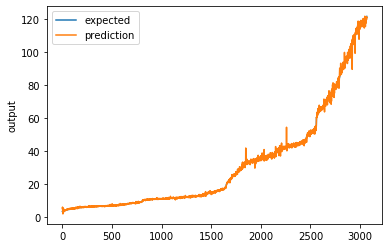

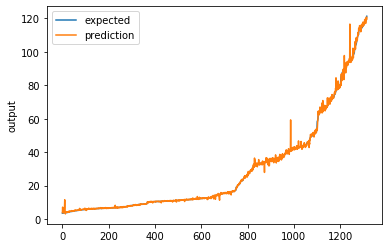

In [19]:
   # Predict and measure RMSE
pred_train = model_relu_adam.predict(X_train)
pred_test = model_relu_adam.predict(X_test)

score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_relu_adam_train (RMSE): {}".format(score_train))

score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_relu_adam_test (RMSE): {}".format(score_test))

    #regression lift Chart
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)


#### NN with 'Sigmoid' activation function and 'adam' optimizer

In [20]:
model_sigmoid = Sequential()

model_sigmoid.add(Dense(36, input_dim = X_train.shape[1], activation='sigmoid'))
model_sigmoid.add(Dense(20,activation='sigmoid'))
model_sigmoid.add(Dense(5,activation='sigmoid'))
#model.add(Dense(3,activation='relu'))
model_sigmoid.add(Dense(1))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99999, epsilon=None, decay=0, amsgrad=False)
model_sigmoid.compile(loss='mean_squared_error', optimizer= adam)


    # patience: number of epochs with no improvement after which training will be stopped

    # The test set is checked during training to monitor progress for early stopping but is never used for gradient descent (model training)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="best_weights_nn_sigmoid.hdf5", verbose=0, save_best_only=True) # save best model

model_sigmoid.fit(X_train, y_train, validation_data=(X_test,y_test), callbacks=[monitor,checkpointer], verbose=2,batch_size=32, epochs=1000) 

model_sigmoid.load_weights('best_weights_nn_sigmoid.hdf5') # load weights from best model


Train on 3069 samples, validate on 1316 samples
Epoch 1/1000
3069/3069 - 1s - loss: 1813.0880 - val_loss: 1623.1858
Epoch 2/1000
3069/3069 - 0s - loss: 1751.9735 - val_loss: 1576.1749
Epoch 3/1000
3069/3069 - 0s - loss: 1709.8300 - val_loss: 1541.8575
Epoch 4/1000
3069/3069 - 0s - loss: 1676.2397 - val_loss: 1512.8895
Epoch 5/1000
3069/3069 - 0s - loss: 1646.6561 - val_loss: 1486.1111
Epoch 6/1000
3069/3069 - 0s - loss: 1619.1879 - val_loss: 1461.4967
Epoch 7/1000
3069/3069 - 0s - loss: 1593.3191 - val_loss: 1437.7167
Epoch 8/1000
3069/3069 - 1s - loss: 1568.5129 - val_loss: 1415.1828
Epoch 9/1000
3069/3069 - 0s - loss: 1544.6400 - val_loss: 1393.5511
Epoch 10/1000
3069/3069 - 0s - loss: 1521.6436 - val_loss: 1372.4193
Epoch 11/1000
3069/3069 - 0s - loss: 1499.4394 - val_loss: 1352.2388
Epoch 12/1000
3069/3069 - 0s - loss: 1478.0341 - val_loss: 1332.5802
Epoch 13/1000
3069/3069 - 0s - loss: 1457.2643 - val_loss: 1313.9156
Epoch 14/1000
3069/3069 - 0s - loss: 1437.2184 - val_loss: 1295.

Epoch 122/1000
3069/3069 - 0s - loss: 422.1614 - val_loss: 371.3440
Epoch 123/1000
3069/3069 - 0s - loss: 418.3818 - val_loss: 367.8854
Epoch 124/1000
3069/3069 - 0s - loss: 414.6522 - val_loss: 364.4963
Epoch 125/1000
3069/3069 - 0s - loss: 410.9884 - val_loss: 361.0457
Epoch 126/1000
3069/3069 - 0s - loss: 407.3377 - val_loss: 357.7382
Epoch 127/1000
3069/3069 - 0s - loss: 403.7298 - val_loss: 354.4464
Epoch 128/1000
3069/3069 - 0s - loss: 400.1531 - val_loss: 351.1963
Epoch 129/1000
3069/3069 - 0s - loss: 396.6444 - val_loss: 347.9360
Epoch 130/1000
3069/3069 - 0s - loss: 393.1505 - val_loss: 344.7947
Epoch 131/1000
3069/3069 - 0s - loss: 389.6830 - val_loss: 341.6006
Epoch 132/1000
3069/3069 - 0s - loss: 386.2636 - val_loss: 338.3873
Epoch 133/1000
3069/3069 - 0s - loss: 382.8640 - val_loss: 335.3175
Epoch 134/1000
3069/3069 - 0s - loss: 379.5111 - val_loss: 332.2727
Epoch 135/1000
3069/3069 - 0s - loss: 376.2009 - val_loss: 329.1980
Epoch 136/1000
3069/3069 - 0s - loss: 372.9027 -

Epoch 243/1000
3069/3069 - 0s - loss: 151.1887 - val_loss: 125.7549
Epoch 244/1000
3069/3069 - 0s - loss: 149.9901 - val_loss: 124.7256
Epoch 245/1000
3069/3069 - 0s - loss: 148.8120 - val_loss: 123.7062
Epoch 246/1000
3069/3069 - 0s - loss: 147.6390 - val_loss: 122.6874
Epoch 247/1000
3069/3069 - 0s - loss: 146.4824 - val_loss: 121.7409
Epoch 248/1000
3069/3069 - 0s - loss: 145.3568 - val_loss: 120.6810
Epoch 249/1000
3069/3069 - 0s - loss: 144.1988 - val_loss: 119.7308
Epoch 250/1000
3069/3069 - 0s - loss: 143.0925 - val_loss: 118.6846
Epoch 251/1000
3069/3069 - 0s - loss: 141.9630 - val_loss: 117.7495
Epoch 252/1000
3069/3069 - 0s - loss: 140.8541 - val_loss: 116.7577
Epoch 253/1000
3069/3069 - 0s - loss: 139.7793 - val_loss: 115.7919
Epoch 254/1000
3069/3069 - 0s - loss: 138.7009 - val_loss: 114.8710
Epoch 255/1000
3069/3069 - 0s - loss: 137.6074 - val_loss: 113.9524
Epoch 256/1000
3069/3069 - 0s - loss: 136.5472 - val_loss: 112.9885
Epoch 257/1000
3069/3069 - 0s - loss: 135.4986 -

Epoch 366/1000
3069/3069 - 0s - loss: 61.1030 - val_loss: 48.3006
Epoch 367/1000
3069/3069 - 0s - loss: 60.5859 - val_loss: 47.7743
Epoch 368/1000
3069/3069 - 0s - loss: 60.2442 - val_loss: 47.3829
Epoch 369/1000
3069/3069 - 0s - loss: 59.7930 - val_loss: 47.0544
Epoch 370/1000
3069/3069 - 0s - loss: 59.3602 - val_loss: 46.6861
Epoch 371/1000
3069/3069 - 0s - loss: 58.9074 - val_loss: 46.4173
Epoch 372/1000
3069/3069 - 0s - loss: 58.5473 - val_loss: 45.9938
Epoch 373/1000
3069/3069 - 0s - loss: 58.0975 - val_loss: 45.7721
Epoch 374/1000
3069/3069 - 0s - loss: 57.7710 - val_loss: 45.3390
Epoch 375/1000
3069/3069 - 0s - loss: 57.3141 - val_loss: 44.9475
Epoch 376/1000
3069/3069 - 0s - loss: 56.9530 - val_loss: 44.6712
Epoch 377/1000
3069/3069 - 0s - loss: 56.5427 - val_loss: 44.3491
Epoch 378/1000
3069/3069 - 0s - loss: 56.1177 - val_loss: 44.0263
Epoch 379/1000
3069/3069 - 0s - loss: 55.7207 - val_loss: 43.6665
Epoch 380/1000
3069/3069 - 0s - loss: 55.3332 - val_loss: 43.3284
Epoch 381/

3069/3069 - 0s - loss: 26.7166 - val_loss: 20.1094
Epoch 491/1000
3069/3069 - 0s - loss: 26.5561 - val_loss: 20.1978
Epoch 492/1000
3069/3069 - 0s - loss: 26.4316 - val_loss: 19.9668
Epoch 493/1000
3069/3069 - 0s - loss: 26.2828 - val_loss: 19.7765
Epoch 494/1000
3069/3069 - 0s - loss: 26.0482 - val_loss: 19.6399
Epoch 495/1000
3069/3069 - 0s - loss: 25.8980 - val_loss: 19.6008
Epoch 496/1000
3069/3069 - 0s - loss: 25.8417 - val_loss: 19.3769
Epoch 497/1000
3069/3069 - 0s - loss: 25.5804 - val_loss: 19.2356
Epoch 498/1000
3069/3069 - 0s - loss: 25.4186 - val_loss: 19.0871
Epoch 499/1000
3069/3069 - 0s - loss: 25.2366 - val_loss: 19.0720
Epoch 500/1000
3069/3069 - 0s - loss: 25.0830 - val_loss: 18.9920
Epoch 501/1000
3069/3069 - 0s - loss: 24.9516 - val_loss: 18.7037
Epoch 502/1000
3069/3069 - 0s - loss: 24.7901 - val_loss: 18.6575
Epoch 503/1000
3069/3069 - 0s - loss: 24.6616 - val_loss: 18.4898
Epoch 504/1000
3069/3069 - 0s - loss: 24.5104 - val_loss: 18.5998
Epoch 505/1000
3069/3069 

Epoch 615/1000
3069/3069 - 0s - loss: 12.7291 - val_loss: 9.5632
Epoch 616/1000
3069/3069 - 0s - loss: 12.6371 - val_loss: 9.4705
Epoch 617/1000
3069/3069 - 0s - loss: 12.5835 - val_loss: 9.5013
Epoch 618/1000
3069/3069 - 0s - loss: 12.4772 - val_loss: 9.3337
Epoch 619/1000
3069/3069 - 0s - loss: 12.4097 - val_loss: 9.2964
Epoch 620/1000
3069/3069 - 0s - loss: 12.3762 - val_loss: 9.2943
Epoch 621/1000
3069/3069 - 0s - loss: 12.3107 - val_loss: 9.2960
Epoch 622/1000
3069/3069 - 0s - loss: 12.2412 - val_loss: 9.1284
Epoch 623/1000
3069/3069 - 0s - loss: 12.1042 - val_loss: 9.0631
Epoch 624/1000
3069/3069 - 0s - loss: 12.0407 - val_loss: 9.2387
Epoch 625/1000
3069/3069 - 0s - loss: 12.0237 - val_loss: 9.0375
Epoch 626/1000
3069/3069 - 0s - loss: 12.0153 - val_loss: 8.9255
Epoch 627/1000
3069/3069 - 0s - loss: 11.9295 - val_loss: 8.9446
Epoch 628/1000
3069/3069 - 0s - loss: 11.8587 - val_loss: 9.0253
Epoch 629/1000
3069/3069 - 0s - loss: 11.7174 - val_loss: 8.7690
Epoch 630/1000
3069/3069 

Epoch 743/1000
3069/3069 - 0s - loss: 6.2323 - val_loss: 4.9135
Epoch 744/1000
3069/3069 - 0s - loss: 6.2264 - val_loss: 4.7829
Epoch 745/1000
3069/3069 - 0s - loss: 6.1906 - val_loss: 4.7335
Epoch 746/1000
3069/3069 - 0s - loss: 6.2474 - val_loss: 4.7421
Epoch 747/1000
3069/3069 - 0s - loss: 6.1157 - val_loss: 4.9405
Epoch 748/1000
3069/3069 - 0s - loss: 6.1052 - val_loss: 4.6812
Epoch 749/1000
3069/3069 - 0s - loss: 6.0661 - val_loss: 5.0714
Epoch 750/1000
3069/3069 - 0s - loss: 6.0849 - val_loss: 4.6662
Epoch 751/1000
3069/3069 - 0s - loss: 6.0294 - val_loss: 4.6865
Epoch 752/1000
3069/3069 - 0s - loss: 6.0678 - val_loss: 5.1369
Epoch 753/1000
3069/3069 - 0s - loss: 6.0755 - val_loss: 4.9663
Epoch 754/1000
3069/3069 - 0s - loss: 5.9395 - val_loss: 4.5191
Epoch 755/1000
3069/3069 - 0s - loss: 5.9734 - val_loss: 4.4959
Epoch 756/1000
3069/3069 - 0s - loss: 5.8463 - val_loss: 4.6589
Epoch 757/1000
3069/3069 - 0s - loss: 5.9276 - val_loss: 4.5044
Epoch 758/1000
3069/3069 - 0s - loss: 5.

Score_sigmoid_adam_train (RMSE): 2.3062407970428467
Score_sigmoid_adam_test (RMSE): 2.0306038856506348


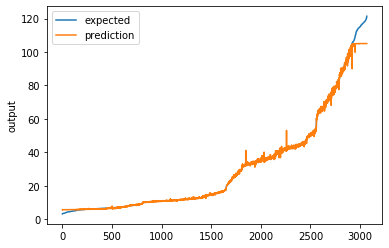

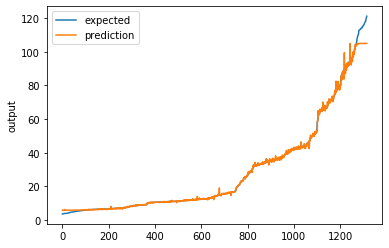

In [21]:
   # Predict and measure RMSE
pred_train = model_sigmoid.predict(X_train)
pred_test = model_sigmoid.predict(X_test)

score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_sigmoid_adam_train (RMSE): {}".format(score_train))

score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_sigmoid_adam_test (RMSE): {}".format(score_test))

    #regression lift Chart
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)


#### NN with 'Tanh' activation function and 'adam' optimizer

In [22]:
model_tanh = Sequential()

model_tanh.add(Dense(36, input_dim = X_train.shape[1], activation='sigmoid'))
model_tanh.add(Dense(20,activation='sigmoid'))
model_tanh.add(Dense(5,activation='sigmoid'))
#model.add(Dense(3,activation='relu'))
model_tanh.add(Dense(1))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99999, epsilon=None, decay=0, amsgrad=False)
model_tanh.compile(loss='mean_squared_error', optimizer= adam)


    # patience: number of epochs with no improvement after which training will be stopped

    # The test set is checked during training to monitor progress for early stopping but is never used for gradient descent (model training)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="best_weights_nn_tanh.hdf5", verbose=0, save_best_only=True) # save best model

model_tanh.fit(X_train, y_train, validation_data=(X_test,y_test), callbacks=[monitor,checkpointer], verbose=2,batch_size=32, epochs=1000) 

model_tanh.load_weights('best_weights_nn_tanh.hdf5') # load weights from best model


Train on 3069 samples, validate on 1316 samples
Epoch 1/1000
3069/3069 - 2s - loss: 1858.6198 - val_loss: 1665.5358
Epoch 2/1000
3069/3069 - 0s - loss: 1802.4772 - val_loss: 1628.5674
Epoch 3/1000
3069/3069 - 0s - loss: 1770.3419 - val_loss: 1602.6316
Epoch 4/1000
3069/3069 - 0s - loss: 1744.5091 - val_loss: 1579.6507
Epoch 5/1000
3069/3069 - 0s - loss: 1720.8622 - val_loss: 1558.0526
Epoch 6/1000
3069/3069 - 1s - loss: 1698.4045 - val_loss: 1537.5225
Epoch 7/1000
3069/3069 - 0s - loss: 1676.8196 - val_loss: 1517.7098
Epoch 8/1000
3069/3069 - 0s - loss: 1655.9250 - val_loss: 1498.4515
Epoch 9/1000
3069/3069 - 0s - loss: 1635.5832 - val_loss: 1479.9056
Epoch 10/1000
3069/3069 - 0s - loss: 1615.8467 - val_loss: 1461.5046
Epoch 11/1000
3069/3069 - 0s - loss: 1596.5589 - val_loss: 1443.8793
Epoch 12/1000
3069/3069 - 0s - loss: 1577.8031 - val_loss: 1426.5084
Epoch 13/1000
3069/3069 - 0s - loss: 1559.4616 - val_loss: 1409.6775
Epoch 14/1000
3069/3069 - 0s - loss: 1541.5686 - val_loss: 1393.

Epoch 121/1000
3069/3069 - 0s - loss: 558.3738 - val_loss: 496.1448
Epoch 122/1000
3069/3069 - 0s - loss: 553.9919 - val_loss: 492.1899
Epoch 123/1000
3069/3069 - 0s - loss: 549.6622 - val_loss: 488.1382
Epoch 124/1000
3069/3069 - 0s - loss: 545.3632 - val_loss: 484.2725
Epoch 125/1000
3069/3069 - 0s - loss: 541.1191 - val_loss: 480.4084
Epoch 126/1000
3069/3069 - 0s - loss: 536.9156 - val_loss: 476.6187
Epoch 127/1000
3069/3069 - 0s - loss: 532.7680 - val_loss: 472.8268
Epoch 128/1000
3069/3069 - 0s - loss: 528.6606 - val_loss: 469.0511
Epoch 129/1000
3069/3069 - 0s - loss: 524.5878 - val_loss: 465.3376
Epoch 130/1000
3069/3069 - 0s - loss: 520.5821 - val_loss: 461.6539
Epoch 131/1000
3069/3069 - 0s - loss: 516.5863 - val_loss: 458.0674
Epoch 132/1000
3069/3069 - 0s - loss: 512.6485 - val_loss: 454.4128
Epoch 133/1000
3069/3069 - 0s - loss: 508.7481 - val_loss: 450.9062
Epoch 134/1000
3069/3069 - 0s - loss: 504.8855 - val_loss: 447.3382
Epoch 135/1000
3069/3069 - 0s - loss: 501.0683 -

Epoch 242/1000
3069/3069 - 0s - loss: 236.7339 - val_loss: 202.0487
Epoch 243/1000
3069/3069 - 0s - loss: 235.0871 - val_loss: 200.5340
Epoch 244/1000
3069/3069 - 0s - loss: 233.4891 - val_loss: 199.1146
Epoch 245/1000
3069/3069 - 0s - loss: 231.9175 - val_loss: 197.7045
Epoch 246/1000
3069/3069 - 0s - loss: 230.3299 - val_loss: 196.2158
Epoch 247/1000
3069/3069 - 0s - loss: 228.7604 - val_loss: 194.7963
Epoch 248/1000
3069/3069 - 0s - loss: 227.2036 - val_loss: 193.4131
Epoch 249/1000
3069/3069 - 0s - loss: 225.6641 - val_loss: 191.9982
Epoch 250/1000
3069/3069 - 0s - loss: 224.1322 - val_loss: 190.7100
Epoch 251/1000
3069/3069 - 0s - loss: 222.6277 - val_loss: 189.2894
Epoch 252/1000
3069/3069 - 0s - loss: 221.1193 - val_loss: 187.9093
Epoch 253/1000
3069/3069 - 0s - loss: 219.6087 - val_loss: 186.5359
Epoch 254/1000
3069/3069 - 0s - loss: 218.1253 - val_loss: 185.2093
Epoch 255/1000
3069/3069 - 0s - loss: 216.6339 - val_loss: 183.9373
Epoch 256/1000
3069/3069 - 0s - loss: 215.1839 -

Epoch 363/1000
3069/3069 - 0s - loss: 108.6318 - val_loss: 88.6442
Epoch 364/1000
3069/3069 - 0s - loss: 107.9866 - val_loss: 88.0779
Epoch 365/1000
3069/3069 - 0s - loss: 107.3274 - val_loss: 87.5248
Epoch 366/1000
3069/3069 - 0s - loss: 106.6922 - val_loss: 86.9417
Epoch 367/1000
3069/3069 - 0s - loss: 106.0237 - val_loss: 86.4137
Epoch 368/1000
3069/3069 - 0s - loss: 105.3882 - val_loss: 85.9183
Epoch 369/1000
3069/3069 - 0s - loss: 104.7843 - val_loss: 85.4465
Epoch 370/1000
3069/3069 - 0s - loss: 104.1332 - val_loss: 84.7771
Epoch 371/1000
3069/3069 - 0s - loss: 103.5239 - val_loss: 84.3570
Epoch 372/1000
3069/3069 - 0s - loss: 102.9090 - val_loss: 83.7369
Epoch 373/1000
3069/3069 - 0s - loss: 102.2801 - val_loss: 83.2037
Epoch 374/1000
3069/3069 - 0s - loss: 101.6849 - val_loss: 82.7284
Epoch 375/1000
3069/3069 - 0s - loss: 101.0850 - val_loss: 82.1481
Epoch 376/1000
3069/3069 - 0s - loss: 100.5038 - val_loss: 81.6495
Epoch 377/1000
3069/3069 - 0s - loss: 99.9026 - val_loss: 81.1

Epoch 487/1000
3069/3069 - 0s - loss: 53.1431 - val_loss: 41.7667
Epoch 488/1000
3069/3069 - 0s - loss: 52.7994 - val_loss: 41.3758
Epoch 489/1000
3069/3069 - 0s - loss: 52.4955 - val_loss: 41.0432
Epoch 490/1000
3069/3069 - 0s - loss: 52.2270 - val_loss: 41.0083
Epoch 491/1000
3069/3069 - 0s - loss: 51.9408 - val_loss: 40.5674
Epoch 492/1000
3069/3069 - 0s - loss: 51.6711 - val_loss: 40.4544
Epoch 493/1000
3069/3069 - 0s - loss: 51.3291 - val_loss: 40.1252
Epoch 494/1000
3069/3069 - 0s - loss: 51.0993 - val_loss: 39.8894
Epoch 495/1000
3069/3069 - 0s - loss: 50.7750 - val_loss: 39.6517
Epoch 496/1000
3069/3069 - 0s - loss: 50.4930 - val_loss: 39.6327
Epoch 497/1000
3069/3069 - 0s - loss: 50.2786 - val_loss: 39.1796
Epoch 498/1000
3069/3069 - 0s - loss: 49.9881 - val_loss: 38.9077
Epoch 499/1000
3069/3069 - 0s - loss: 49.6402 - val_loss: 38.7313
Epoch 500/1000
3069/3069 - 0s - loss: 49.3839 - val_loss: 38.5125
Epoch 501/1000
3069/3069 - 0s - loss: 49.1347 - val_loss: 38.2579
Epoch 502/

3069/3069 - 0s - loss: 27.3264 - val_loss: 20.8327
Epoch 612/1000
3069/3069 - 0s - loss: 27.1986 - val_loss: 20.4213
Epoch 613/1000
3069/3069 - 0s - loss: 27.0302 - val_loss: 20.4614
Epoch 614/1000
3069/3069 - 0s - loss: 26.8804 - val_loss: 20.2918
Epoch 615/1000
3069/3069 - 0s - loss: 26.7501 - val_loss: 20.1110
Epoch 616/1000
3069/3069 - 0s - loss: 26.6143 - val_loss: 19.9930
Epoch 617/1000
3069/3069 - 0s - loss: 26.5479 - val_loss: 19.9784
Epoch 618/1000
3069/3069 - 0s - loss: 26.3361 - val_loss: 19.7949
Epoch 619/1000
3069/3069 - 0s - loss: 26.2435 - val_loss: 19.6512
Epoch 620/1000
3069/3069 - 0s - loss: 26.0594 - val_loss: 19.5966
Epoch 621/1000
3069/3069 - 0s - loss: 25.9914 - val_loss: 19.4934
Epoch 622/1000
3069/3069 - 0s - loss: 25.8209 - val_loss: 19.3434
Epoch 623/1000
3069/3069 - 0s - loss: 25.7890 - val_loss: 19.2474
Epoch 624/1000
3069/3069 - 0s - loss: 25.5562 - val_loss: 19.1735
Epoch 625/1000
3069/3069 - 0s - loss: 25.4163 - val_loss: 19.1017
Epoch 626/1000
3069/3069 

Epoch 736/1000
3069/3069 - 0s - loss: 14.7830 - val_loss: 11.1624
Epoch 737/1000
3069/3069 - 0s - loss: 14.7463 - val_loss: 11.2608
Epoch 738/1000
3069/3069 - 0s - loss: 14.6331 - val_loss: 11.4515
Epoch 739/1000
3069/3069 - 0s - loss: 14.6307 - val_loss: 10.9148
Epoch 740/1000
3069/3069 - 0s - loss: 14.5271 - val_loss: 10.8381
Epoch 741/1000
3069/3069 - 0s - loss: 14.4220 - val_loss: 11.0202
Epoch 742/1000
3069/3069 - 0s - loss: 14.3740 - val_loss: 10.8238
Epoch 743/1000
3069/3069 - 0s - loss: 14.3133 - val_loss: 10.7244
Epoch 744/1000
3069/3069 - 0s - loss: 14.2141 - val_loss: 10.6760
Epoch 745/1000
3069/3069 - 0s - loss: 14.1281 - val_loss: 10.6294
Epoch 746/1000
3069/3069 - 0s - loss: 14.0653 - val_loss: 10.7463
Epoch 747/1000
3069/3069 - 0s - loss: 14.0683 - val_loss: 10.6424
Epoch 748/1000
3069/3069 - 0s - loss: 13.9101 - val_loss: 10.6871
Epoch 749/1000
3069/3069 - 0s - loss: 13.9036 - val_loss: 10.4620
Epoch 750/1000
3069/3069 - 0s - loss: 13.8179 - val_loss: 10.4040
Epoch 751/

Epoch 863/1000
3069/3069 - 0s - loss: 8.3039 - val_loss: 6.4389
Epoch 864/1000
3069/3069 - 0s - loss: 8.2084 - val_loss: 6.3789
Epoch 865/1000
3069/3069 - 0s - loss: 8.1441 - val_loss: 6.3993
Epoch 866/1000
3069/3069 - 0s - loss: 8.0902 - val_loss: 6.4586
Epoch 867/1000
3069/3069 - 0s - loss: 8.1153 - val_loss: 6.8126
Epoch 868/1000
3069/3069 - 0s - loss: 8.0550 - val_loss: 6.2202
Epoch 869/1000
3069/3069 - 0s - loss: 7.9548 - val_loss: 6.1972
Epoch 870/1000
3069/3069 - 0s - loss: 7.9640 - val_loss: 6.1720
Epoch 871/1000
3069/3069 - 0s - loss: 7.9158 - val_loss: 6.2391
Epoch 872/1000
3069/3069 - 0s - loss: 7.8818 - val_loss: 6.1640
Epoch 873/1000
3069/3069 - 0s - loss: 7.8279 - val_loss: 6.1465
Epoch 874/1000
3069/3069 - 0s - loss: 7.7950 - val_loss: 6.1338
Epoch 875/1000
3069/3069 - 0s - loss: 7.7975 - val_loss: 6.1053
Epoch 876/1000
3069/3069 - 0s - loss: 7.8113 - val_loss: 6.1361
Epoch 877/1000
3069/3069 - 0s - loss: 7.7202 - val_loss: 6.0293
Epoch 878/1000
3069/3069 - 0s - loss: 7.

Score_tanh_adam_train (RMSE): 2.6500062942504883
Score_tanh_adam_test (RMSE): 2.353583812713623


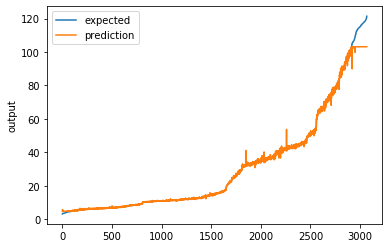

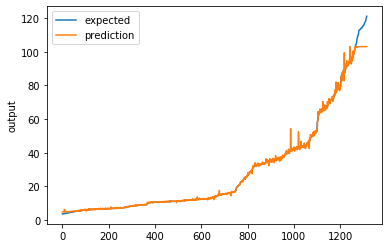

In [23]:
   # Predict and measure RMSE
pred_train = model_tanh.predict(X_train)
pred_test = model_tanh.predict(X_test)

score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_tanh_adam_train (RMSE): {}".format(score_train))

score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_tanh_adam_test (RMSE): {}".format(score_test))

    #regression lift Chart
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)


#### NN with 'Relu' activation function and 'sgd' optimizer

In [24]:
from tensorflow.keras import optimizers
model_relu_sgd = Sequential()

model_relu_sgd.add(Dense(36, input_dim = X_train.shape[1], activation='relu',kernel_initializer='Constant'))
model_relu_sgd.add(Dense(20,activation='relu'))
model_relu_sgd.add(Dense(5,activation='relu'))
#model.add(Dense(3,activation='relu'))
model_relu_sgd.add(Dense(1))
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99999, epsilon=None, decay=0, amsgrad=False)
model_relu_sgd.compile(loss='mean_squared_error', optimizer= 'sgd')


    # patience: number of epochs with no improvement after which training will be stopped

    # The test set is checked during training to monitor progress for early stopping but is never used for gradient descent (model training)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="best_weights_nn_relu_sgd.hdf5", verbose=0, save_best_only=True) # save best model

model_relu_sgd.fit(X_train, y_train, validation_data=(X_test,y_test), callbacks=[monitor,checkpointer], verbose=2,batch_size=32, epochs=1000)

model_relu_sgd.load_weights('best_weights_nn_relu_sgd.hdf5') # load weights from best model



Train on 3069 samples, validate on 1316 samples
Epoch 1/1000
3069/3069 - 2s - loss: 1158.4464 - val_loss: 863.3599
Epoch 2/1000
3069/3069 - 1s - loss: 915.7827 - val_loss: 857.1565
Epoch 3/1000
3069/3069 - 0s - loss: 910.6090 - val_loss: 858.3239
Epoch 4/1000
3069/3069 - 0s - loss: 910.5080 - val_loss: 858.9736
Epoch 5/1000
3069/3069 - 0s - loss: 910.3957 - val_loss: 860.1037
Epoch 6/1000
3069/3069 - 0s - loss: 910.3868 - val_loss: 861.6025
Epoch 7/1000
3069/3069 - 0s - loss: 910.6938 - val_loss: 858.7608
Epoch 00007: early stopping


Score_relu_sgd_train (RMSE): 30.173059463500977
Score_relu_sgd_test (RMSE): 29.277233123779297


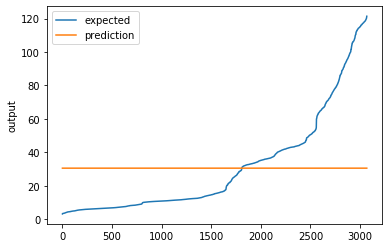

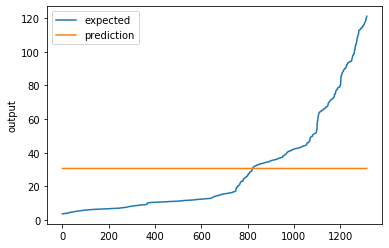

In [25]:
   # Predict and measure RMSE
pred_train = model_relu_sgd.predict(X_train)
pred_test = model_relu_sgd.predict(X_test)

score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_relu_sgd_train (RMSE): {}".format(score_train))

score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_relu_sgd_test (RMSE): {}".format(score_test))

    #regression lift Chart
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)


#### NN with 'Sigmoid' activation function and 'sgd' optimizer

In [26]:
from tensorflow.keras import optimizers
model_sigmoid_sgd = Sequential()

model_sigmoid_sgd.add(Dense(36, input_dim = X_train.shape[1], activation='sigmoid',kernel_initializer='Constant'))
model_sigmoid_sgd.add(Dense(20,activation='sigmoid'))
model_sigmoid_sgd.add(Dense(5,activation='sigmoid'))
#model.add(Dense(3,activation='relu'))
model_sigmoid_sgd.add(Dense(1))
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99999, epsilon=None, decay=0, amsgrad=False)
model_sigmoid_sgd.compile(loss='mean_squared_error', optimizer= 'sgd')


    # patience: number of epochs with no improvement after which training will be stopped

    # The test set is checked during training to monitor progress for early stopping but is never used for gradient descent (model training)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="best_weights_nn_sigmoid_sgd.hdf5", verbose=0, save_best_only=True) # save best model

model_sigmoid_sgd.fit(X_train, y_train, validation_data=(X_test,y_test), callbacks=[monitor,checkpointer], verbose=2,batch_size=32, epochs=1000)

model_sigmoid_sgd.load_weights('best_weights_nn_sigmoid_sgd.hdf5') # load weights from best model



Train on 3069 samples, validate on 1316 samples
Epoch 1/1000
3069/3069 - 1s - loss: 594.7713 - val_loss: 197.8086
Epoch 2/1000
3069/3069 - 0s - loss: 138.5167 - val_loss: 59.2227
Epoch 3/1000
3069/3069 - 0s - loss: 74.4743 - val_loss: 186.0289
Epoch 4/1000
3069/3069 - 0s - loss: 116.8097 - val_loss: 130.6154
Epoch 5/1000
3069/3069 - 0s - loss: 85.8216 - val_loss: 44.8186
Epoch 6/1000
3069/3069 - 0s - loss: 52.8908 - val_loss: 46.8577
Epoch 7/1000
3069/3069 - 0s - loss: 61.2526 - val_loss: 39.8701
Epoch 8/1000
3069/3069 - 0s - loss: 53.9308 - val_loss: 47.4667
Epoch 9/1000
3069/3069 - 0s - loss: 60.3226 - val_loss: 20.5455
Epoch 10/1000
3069/3069 - 0s - loss: 26.6879 - val_loss: 11.5205
Epoch 11/1000
3069/3069 - 0s - loss: 19.5409 - val_loss: 9.1932
Epoch 12/1000
3069/3069 - 0s - loss: 22.1119 - val_loss: 15.3218
Epoch 13/1000
3069/3069 - 0s - loss: 35.7446 - val_loss: 17.1140
Epoch 14/1000
3069/3069 - 0s - loss: 19.8463 - val_loss: 17.2497
Epoch 15/1000
3069/3069 - 0s - loss: 25.1112 -

Score_relu_sgd_train (RMSE): 1.2739801406860352
Score_relu_sgd_test (RMSE): 1.286014437675476


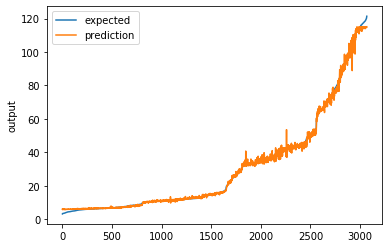

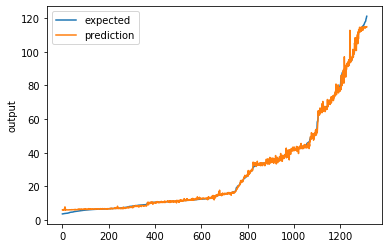

In [27]:
  # Predict and measure RMSE
pred_train = model_sigmoid_sgd.predict(X_train)
pred_test = model_sigmoid_sgd.predict(X_test)

score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_relu_sgd_train (RMSE): {}".format(score_train))

score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_relu_sgd_test (RMSE): {}".format(score_test))

    #regression lift Chart
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)


#### NN with 'Tanh' activation function and 'sgd' optimizer

In [28]:
from tensorflow.keras import optimizers
model_tanh_sgd = Sequential()

model_tanh_sgd.add(Dense(36, input_dim = X_train.shape[1], activation='tanh',kernel_initializer='Constant'))
model_tanh_sgd.add(Dense(20,activation='tanh'))
model_tanh_sgd.add(Dense(5,activation='tanh'))
#model.add(Dense(3,activation='relu'))
model_tanh_sgd.add(Dense(1))
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99999, epsilon=None, decay=0, amsgrad=False)
model_tanh_sgd.compile(loss='mean_squared_error', optimizer= 'sgd')


    # patience: number of epochs with no improvement after which training will be stopped

    # The test set is checked during training to monitor progress for early stopping but is never used for gradient descent (model training)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="best_weights_nn_tanh_sgd.hdf5", verbose=0, save_best_only=True) # save best model


model_tanh_sgd.fit(X_train, y_train, validation_data=(X_test,y_test), callbacks=[monitor,checkpointer], verbose=2,batch_size=32, epochs=1000)

model_tanh_sgd.load_weights('best_weights_nn_tanh_sgd.hdf5') # load weights from best model



Train on 3069 samples, validate on 1316 samples
Epoch 1/1000
3069/3069 - 1s - loss: 598.8082 - val_loss: 284.2733
Epoch 2/1000
3069/3069 - 0s - loss: 401.3204 - val_loss: 304.1381
Epoch 3/1000
3069/3069 - 0s - loss: 332.0101 - val_loss: 288.2870
Epoch 4/1000
3069/3069 - 0s - loss: 317.0829 - val_loss: 255.8091
Epoch 5/1000
3069/3069 - 0s - loss: 242.9867 - val_loss: 113.4851
Epoch 6/1000
3069/3069 - 0s - loss: 242.2950 - val_loss: 198.1329
Epoch 7/1000
3069/3069 - 0s - loss: 182.7393 - val_loss: 132.5645
Epoch 8/1000
3069/3069 - 0s - loss: 224.5929 - val_loss: 174.0616
Epoch 9/1000
3069/3069 - 0s - loss: 217.0145 - val_loss: 129.7618
Epoch 10/1000
3069/3069 - 0s - loss: 328.2696 - val_loss: 200.7908
Epoch 00010: early stopping


Score_relu_sgd_train (RMSE): 11.522486686706543
Score_relu_sgd_test (RMSE): 10.65294075012207


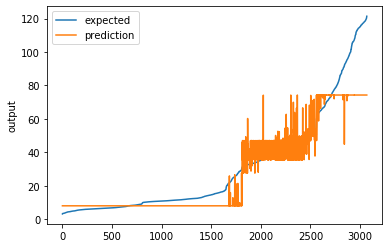

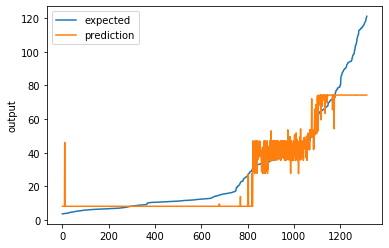

In [29]:
  # Predict and measure RMSE
pred_train = model_tanh_sgd.predict(X_train)
pred_test = model_tanh_sgd.predict(X_test)

score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_relu_sgd_train (RMSE): {}".format(score_train))

score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_relu_sgd_test (RMSE): {}".format(score_test))

    #regression lift Chart
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)
